In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

from torchvision import transforms

from PIL import Image

import numpy as np
from timesformer.models.vit import TimeSformer

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
class DivingViT(nn.Module):
    def __init__(self, pretrained_model, drop_prob=0.5, freeze=False, num_classes=1):
        """
        Builds upon the TimeSformer model with additional MLP layers of (512 > 256 > num_classes).

        Args:
            pretrained_model (TimeSformer): A pretrained instance of TimeSformer of 8 frames and 224x224.
            drop_prob (float, optional): Drop probability for dropout after the TimeSformer model. Defaults to 0.5.
            freeze (bool, optional): Whether to freeze the pretrained model weights or also add them to the gradient updates. Defaults to False.
            num_classes (int, optional): The number of output classes. Defaults to 1.
        """
        super(DivingViT, self).__init__()
        
        self.pretrained_model = pretrained_model
        if freeze:
            pretrained_model.requires_grad_ = False
            
        self.dropout = nn.Dropout(p=drop_prob)
        self.linears = nn.Sequential(
            nn.Linear(in_features=768, out_features=512),
            nn.Linear(in_features=512, out_features=256),
            nn.Linear(in_features=256, out_features=num_classes)
        )
        
    def forward(self, x):
        """
        Computes the forward pass of the model. The input must be in the shape (batch, channels, frames, height, width).
        The output will have the shape of (batch, num_classes).

        Args:
            x (torch.Tensor): The input to the model. It is in the shape (batch, channels, frames, height, width).

        Returns:
            torch.Tensor: Returns the output of the model. It is in the shape (batch, num_classes).
        """
        out = self.pretrained_model(x) # (batch, 768)
        out = self.dropout(out) # (batch, 768)
        out = self.linears(out) # (batch, num_classes)
        return out

In [3]:
# Convertor between PIL to Pytorch Tensor
convert_tensor = transforms.ToTensor()

# A data class to hold a single video clip
class VideoClip:
    PATH_TO_FRAMES = "D:/MTL-AQA-Frames/"
    def __init__(self, video_num, start_frame, end_frame, difficulty, final_score):
        self.video_num = video_num
        self.start_frame = start_frame
        self.end_frame = end_frame
        self.difficulty = difficulty
        self.final_score = final_score
    
    def load(self):
        # Computes the number of frames in the clip
        clip_num_frames = self.end_frame - self.start_frame + 1
        
        # Creates the video clip in torch with (channels x frames x height x width)
        clip = torch.empty(size=(3, 8, 224, 224), dtype=torch.float32)
        
        # Since we are constrained to 8 frames, pick 8 frames from the entire clip
        step_size = clip_num_frames // 8 + 1
        for idx, frame_num in enumerate(range(self.start_frame, self.end_frame + 1, step_size)):
            img_path = VideoClip.PATH_TO_FRAMES + f"{self.video_num:02d}/{frame_num:06d}.jpg"
            img = Image.open(img_path).resize((224, 224))
            tensor = convert_tensor(img).type(dtype=torch.float32) # (channels x height x width)
            clip[:, idx, :, :] = tensor
        
        # Generate the outputs/targets for this clip
        target = torch.tensor([self.final_score], dtype=torch.float32)
        return clip, target

clips_dataset = []
print(f"Loading dataset...")

# Loads all the video clips from the dataset textfile that Mohammad generates. They're in the format video_num,start_frame,end_frame,difficulty,final_score
# where video_num is the video number it came from (01.mp4 is 1, 02.mp4 is 2, etc.)
def load_dataset_file(filename):
    loaded_clips = []
    with open(filename, "r") as f:
        # Read all lines, but skip the header
        for line in f.readlines()[1:]:
            # format: video_num,start_frame,end_frame,difficulty,final_score
            split = line.split(",")
            
            # TODO: Add better checking and error handling
            video_num = int(split[0])
            start_frame = int(split[1])
            end_frame = int(split[2])
            difficulty = float(split[3])
            final_score = float(split[4])
            loaded_clips.append(VideoClip(video_num, start_frame, end_frame, difficulty, final_score))
    print(f"Found {len(loaded_clips)} in {filename}.")
    return loaded_clips

clips_dataset.extend(load_dataset_file("dataset/01.csv"))
# clips_dataset.extend(load_dataset_file("dataset/02.csv"))
# clips_dataset.extend(load_dataset_file("dataset/03.csv"))
# clips_dataset.extend(load_dataset_file("dataset/04.csv"))

print(f"Loaded {len(clips_dataset)} clips in the dataset.")

Loading dataset...
Found 341 in dataset/01.csv.
Loaded 341 clips in the dataset.


In [4]:
class MyDataset(Dataset):
    def __init__(self, clips_dataset):
        self.clips_dataset = clips_dataset
        
    def __len__(self):
        return len(self.clips_dataset)

    def __getitem__(self, index):
        return self.clips_dataset[index].load()

train_dataset = MyDataset(clips_dataset)

In [5]:
batch_size = 2
train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [6]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
epochs = 3
learning_rate = 1e-5

path = "D:/Programming/Github/DeepSports/training/TimeSformer/TimeSformer_divST_8x32_224_K400.pyth"
pretrained_model = TimeSformer(img_size=224, num_classes=768, num_frames=8, attention_type='divided_space_time',  pretrained_model=path)
model = DivingViT(pretrained_model, drop_prob=0.5, freeze=False, num_classes=1).to(device)

opt = optim.Adam(params=model.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

plot_data = {
    "train_loss": []
}

for epoch in range(epochs):
    train_loss = []
    
    # Training
    for (inputs, targets) in train_data_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        opt.zero_grad()
        loss.backward()
        opt.step()
        train_loss.append(loss.item())
    print(f"Epoch {epoch+1}/{epochs} \t train_loss: {np.mean(train_loss):.4f}")
    plot_data["train_loss"].append(np.mean(train_loss))
    
    # Validation every 10th epoch
    # if epoch % 10 == 0:
    #     val_loss = []
    #     with torch.no_grad():
    #         for (inputs, targets) in train_data_loader:
    #             inputs, targets = inputs.to(device), targets.to(device)
    #             outputs = model(inputs)
    #             loss = criterion(outputs, targets)
    #             val_loss.append(loss.item())
    #             print('Outputs', outputs)
    #             print('Targets', targets)
    #     print(f"Epoch {epoch+1}/{epochs} \t val_loss: {np.mean(val_loss):.4f}")

Epoch 1/3 	 train_loss: 4116.3033
Epoch 2/3 	 train_loss: 399.7047
Epoch 3/3 	 train_loss: 227.0480


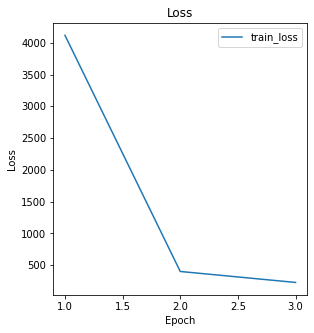

In [7]:
# Plot the training loss

fig = plt.figure(figsize = (10, 5))

epochs_range = list(range(1, epochs+1))

ax1 = plt.subplot(121)
ax1.plot(epochs_range, plot_data["train_loss"], label="train_loss")
ax1.title.set_text("Loss")
ax1.legend()
ax1.set_ylabel("Loss")
ax1.set_xlabel("Epoch")

plt.show()

In [10]:
# See how the predictions were close to the real value
val_loss = []

with torch.no_grad():
    _outputs = []
    _targets = []
    for (inputs, targets) in train_data_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        val_loss.append(loss.item())
        
        # TODO: This is bad code!
        _outputs.append(outputs[0].item())
        _targets.append(targets[0].item())
    
    for i in range(min(30, len(_outputs))): # Use this for loop to show some of the predictions
    # for i in range(len(_outputs)): # Use this for loop to show ALL predictions
        print(f"Predicted {_outputs[i]:.2f}\tExpected {_targets[i]:.2f}")

print(f"Epoch {epoch+1}/{epochs} \t val_loss: {np.mean(val_loss):.4f}")

Predicted 78.69	Expected 95.20
Predicted 70.64	Expected 81.60
Predicted 78.81	Expected 72.00
Predicted 73.27	Expected 54.45
Predicted 71.59	Expected 51.20
Predicted 73.76	Expected 81.00
Predicted 74.83	Expected 66.00
Predicted 74.24	Expected 54.45
Predicted 74.86	Expected 70.20
Predicted 73.65	Expected 76.50
Predicted 73.97	Expected 44.55
Predicted 73.94	Expected 37.95
Predicted 73.94	Expected 64.35
Predicted 74.32	Expected 67.20
Predicted 78.96	Expected 84.15
Predicted 71.92	Expected 97.20
Predicted 76.02	Expected 85.80
Predicted 74.57	Expected 37.70
Predicted 75.66	Expected 49.50
Predicted 75.59	Expected 37.95
Predicted 74.17	Expected 93.60
Predicted 74.65	Expected 59.40
Predicted 71.64	Expected 76.50
Predicted 75.32	Expected 62.40
Predicted 74.71	Expected 66.60
Predicted 75.42	Expected 64.35
Predicted 76.58	Expected 81.60
Predicted 74.10	Expected 72.00
Predicted 68.19	Expected 89.10
Predicted 74.35	Expected 86.40
Epoch 3/3 	 val_loss: 228.4892
